### Zadania

Lista składa się z dwóch sekcji: pierwsza (zadania 1 i 2) dotyczy metod detekcji krawędzi, druga (zadania 3 i 4) operacji na histogramach.

In [1]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

##### Zad. 1: Wyznaczenie gradientów

Wykonaj dla obrazu `coins` sztuczny obraz ilustrujący wielkość (moduł) wektora gradientu w danym punkcie. Do wyświetlenia użyj [mapy kolorów](https://matplotlib.org/stable/tutorials/colors/colormaps.html) `hot` do oznaczenia wielkości gradientu odpowiednim kolorem – im większa wartość, tym bardziej czerwony (_mapa ciepła_).  
Gdzie gradienty są bliskie zera?  
Czy uzyskany wynik pozwoliłby np. na detekcję obiektów?

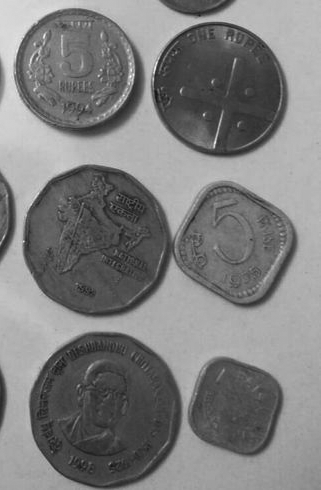

In [2]:
coins = cv2.imread('dane1-4/Monety_szare.bmp', cv2.IMREAD_GRAYSCALE)
# plt.imshow(coins, cmap='hot') # przykład wyświetlania z mapą kolorów
Image.fromarray(coins)

Rozwiązanie:

In [3]:
def compute_gradient_magnitude(image, ksize=3, filter_type='Sobel'):
    
    if filter_type == 'Sobel':
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    elif filter_type == 'Laplacian':
        laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=ksize)
        magnitude = np.abs(laplacian)
    
    elif filter_type == 'Prewitt':
        kernelx = np.array([[ -1, 0, 1],
                            [ -1, 0, 1],
                            [ -1, 0, 1]], dtype=np.float32)
        kernely = np.array([[ 1,  1,  1],
                            [ 0,  0,  0],
                            [-1, -1, -1]], dtype=np.float32)
        grad_x = cv2.filter2D(image, cv2.CV_64F, kernelx)
        grad_y = cv2.filter2D(image, cv2.CV_64F, kernely)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    elif filter_type == 'Scharr':
        grad_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
        grad_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    elif filter_type == 'Roberts':
        kernelx = np.array([[1, 0],
                            [0, -1]], dtype=np.float32)
        kernely = np.array([[0, 1],
                            [-1, 0]], dtype=np.float32)
        grad_x = cv2.filter2D(image, cv2.CV_64F, kernelx)
        grad_y = cv2.filter2D(image, cv2.CV_64F, kernely)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    else:
        raise ValueError(f"Nieznany typ filtra: {filter_type}")
    
    magnitude = np.uint8(255 * magnitude / np.max(magnitude)) if np.max(magnitude) != 0 else np.uint8(magnitude)
    return magnitude

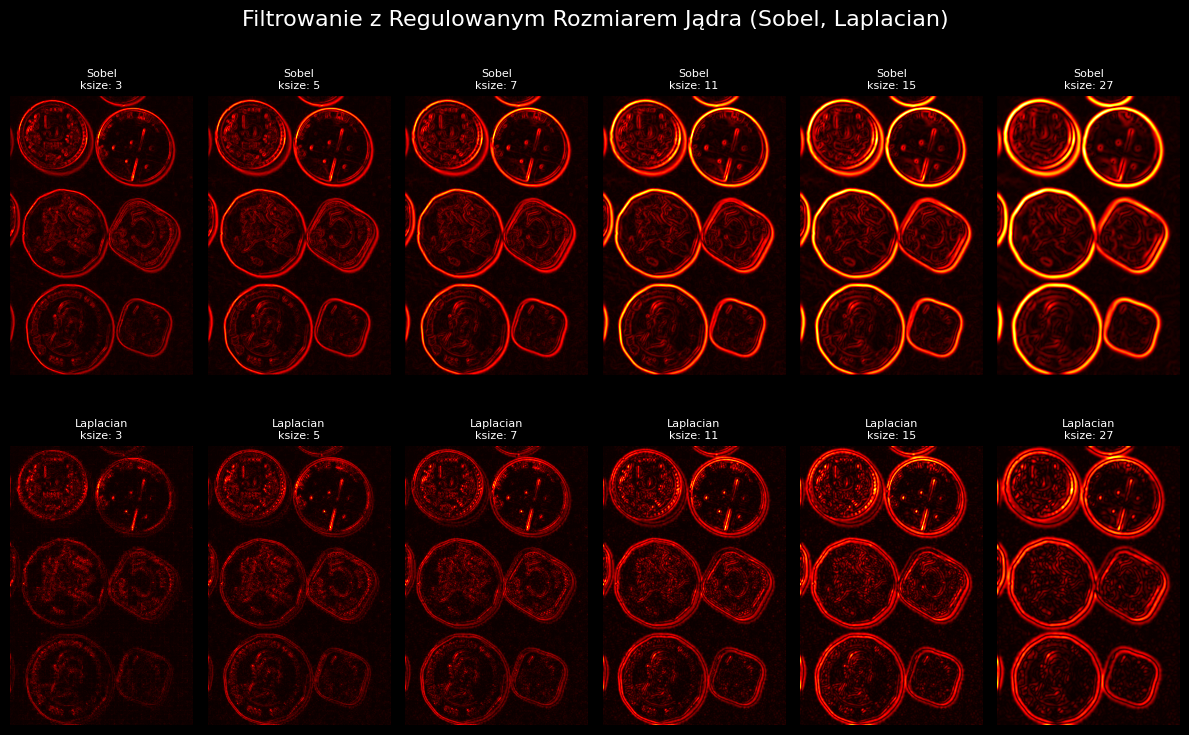

In [4]:
variable_filters = ['Sobel', 'Laplacian']
kernel_sizes = [3, 5, 7, 11, 15, 27]

num_kernels = len(kernel_sizes)
num_variable_filters = len(variable_filters)
plt.figure(figsize=(12, 8))

for i, filter_type in enumerate(variable_filters, 1):
  for j, ksize in enumerate(kernel_sizes, 1):
    magnitude = compute_gradient_magnitude(coins, ksize, filter_type=filter_type)
    
    plt.subplot(num_variable_filters, num_kernels, (i-1)*num_kernels + j)
    plt.imshow(magnitude, cmap='hot')
    title = f'{filter_type}\nksize: {ksize}'
    plt.title(title, fontsize=8)
    plt.axis('off')
    
plt.suptitle('Filtrowanie z Regulowanym Rozmiarem Jądra (Sobel, Laplacian)', fontsize=16)
plt.tight_layout()
plt.show()

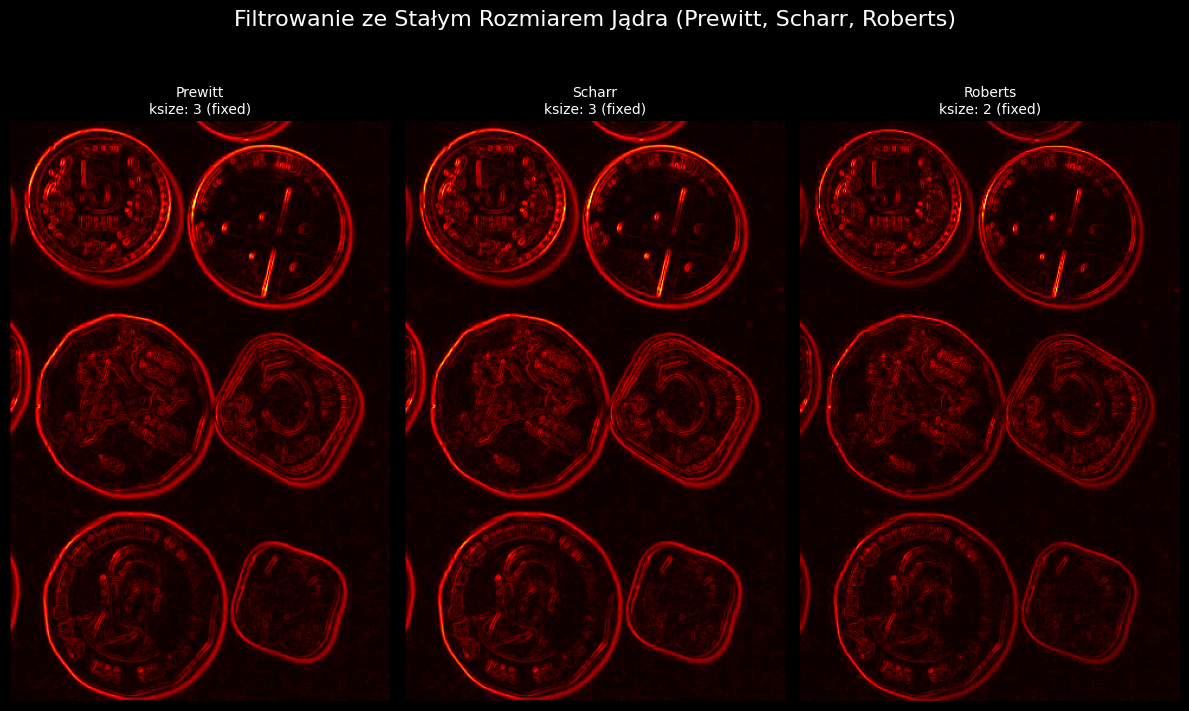

In [5]:
fixed_filters = ['Prewitt', 'Scharr', 'Roberts']

num_fixed_filters = len(fixed_filters)
plt.figure(figsize=(12, 8))

for i, filter_type in enumerate(fixed_filters, 1):
  current_ksize = 3
  if filter_type == 'Roberts':
      current_ksize = 2
  magnitude = compute_gradient_magnitude(coins, current_ksize, filter_type=filter_type)
  plt.subplot(1, num_fixed_filters, i)
  plt.imshow(magnitude, cmap='hot')
  title = f'{filter_type}\nksize: {current_ksize} (fixed)'
  plt.title(title, fontsize=10)
  plt.axis('off')

plt.suptitle('Filtrowanie ze Stałym Rozmiarem Jądra (Prewitt, Scharr, Roberts)', fontsize=16)
plt.tight_layout()
plt.show()

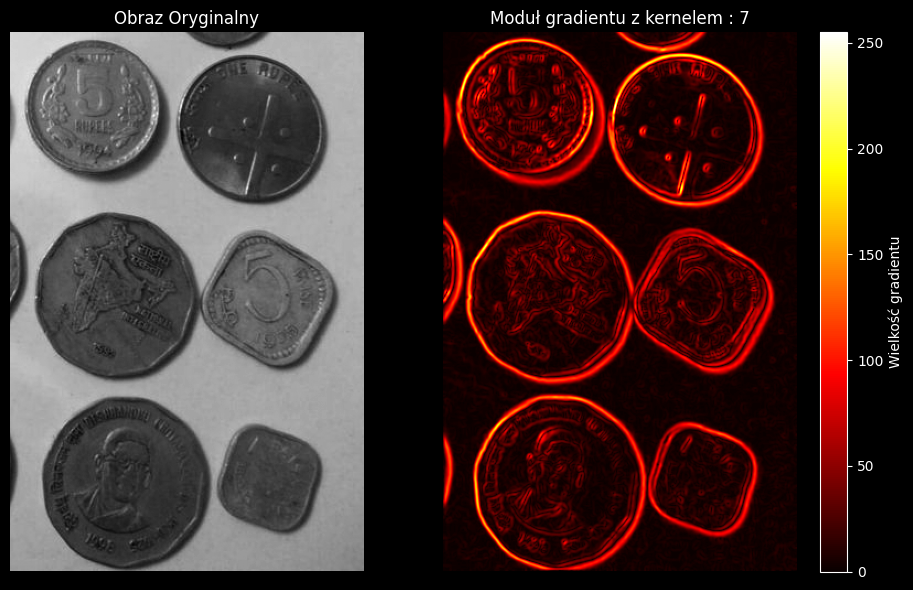

In [6]:
ksize = 7; magnitude = compute_gradient_magnitude(coins, ksize)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].imshow(coins, cmap='gray')
axs[0].set_title('Obraz Oryginalny')
axs[0].axis('off')

im = axs[1].imshow(magnitude, cmap='hot')
axs[1].set_title(f'Moduł gradientu z kernelem : {ksize}')
axs[1].axis('off')
cbar = fig.colorbar(im, ax=axs[1], orientation='vertical')
cbar.set_label('Wielkość gradientu')

plt.tight_layout()
plt.show()

---

##### Zad. 2: Detekcja krawędzi

Przeprowadź z obrazem `coins_noise` takie przekształcenia, aby zmaksymalizować możliwość rozpoznania obiektów. Wykorzystaj [filtr Canny'ego](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) do detekcji krawędzi; zbadaj jego zachowanie w zależności od wartości progów oraz sposobu redukcji szumu.

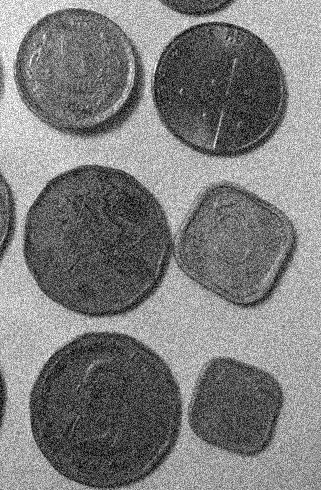

In [7]:
coins_noise = cv2.imread('dane1-4/Monety_szare_szum.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins_noise)

Rozwiązanie:

In [8]:
noise_reduction_filters = {
    'Gaussian Blur': lambda img, k: cv2.GaussianBlur(img, (k, k), 0),
    'Median Blur': lambda img, k: cv2.medianBlur(img, k),
    'Bilateral Filter': lambda img, k: cv2.bilateralFilter(img, k, 75, 75)
}

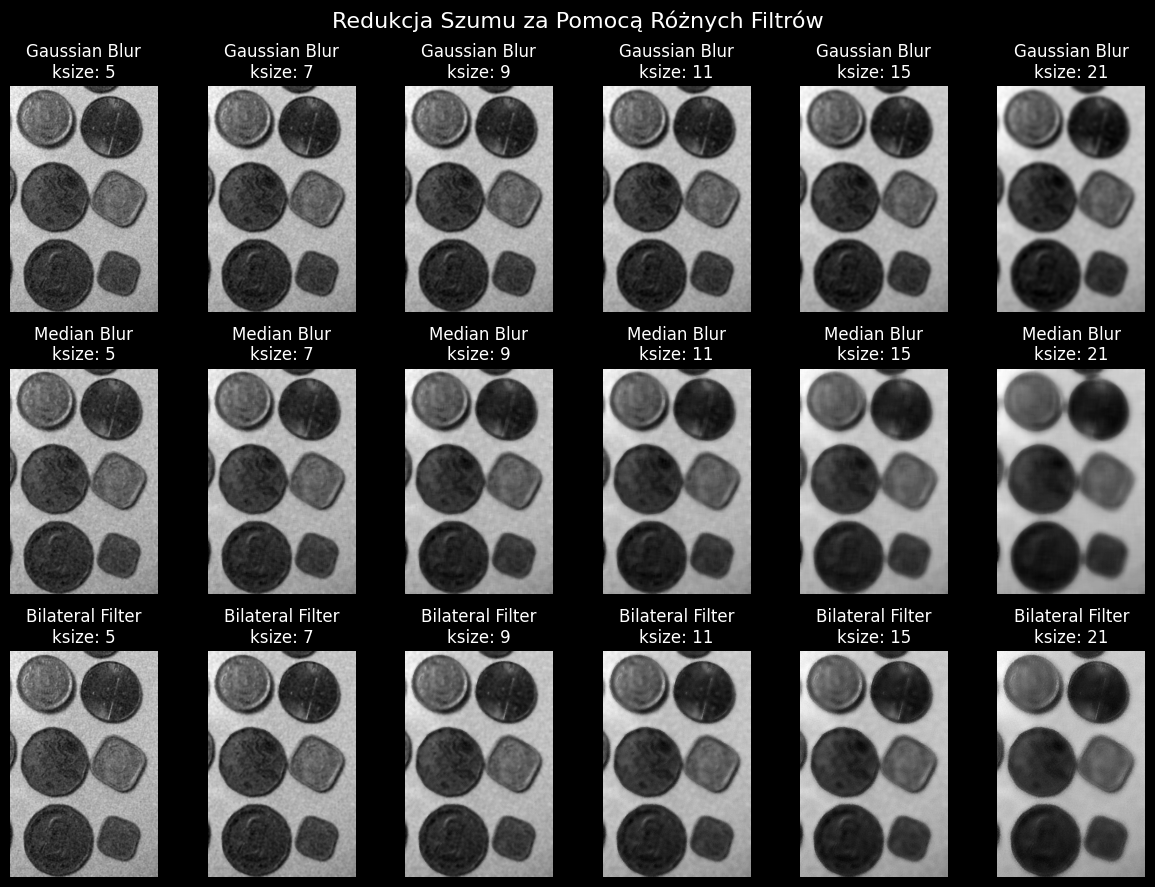

In [9]:
kernel_sizes = [5, 7, 9, 11, 15, 21]

num_filters = len(noise_reduction_filters)
num_kernels = len(kernel_sizes)

plt.figure(figsize=(12, 9))

for i, (filter_name, filter_func) in enumerate(noise_reduction_filters.items(), 1):
  for j, ksize in enumerate(kernel_sizes, 1):
    
    filtered_img = filter_func(coins_noise, ksize)

    plt.subplot(num_filters, num_kernels, (i-1)*num_kernels + j)
    plt.imshow(filtered_img, cmap='gray')
    plt.title(f'{filter_name}\nksize: {ksize}')
    plt.axis('off')

plt.suptitle('Redukcja Szumu za Pomocą Różnych Filtrów', fontsize=16)
plt.tight_layout()
plt.show()

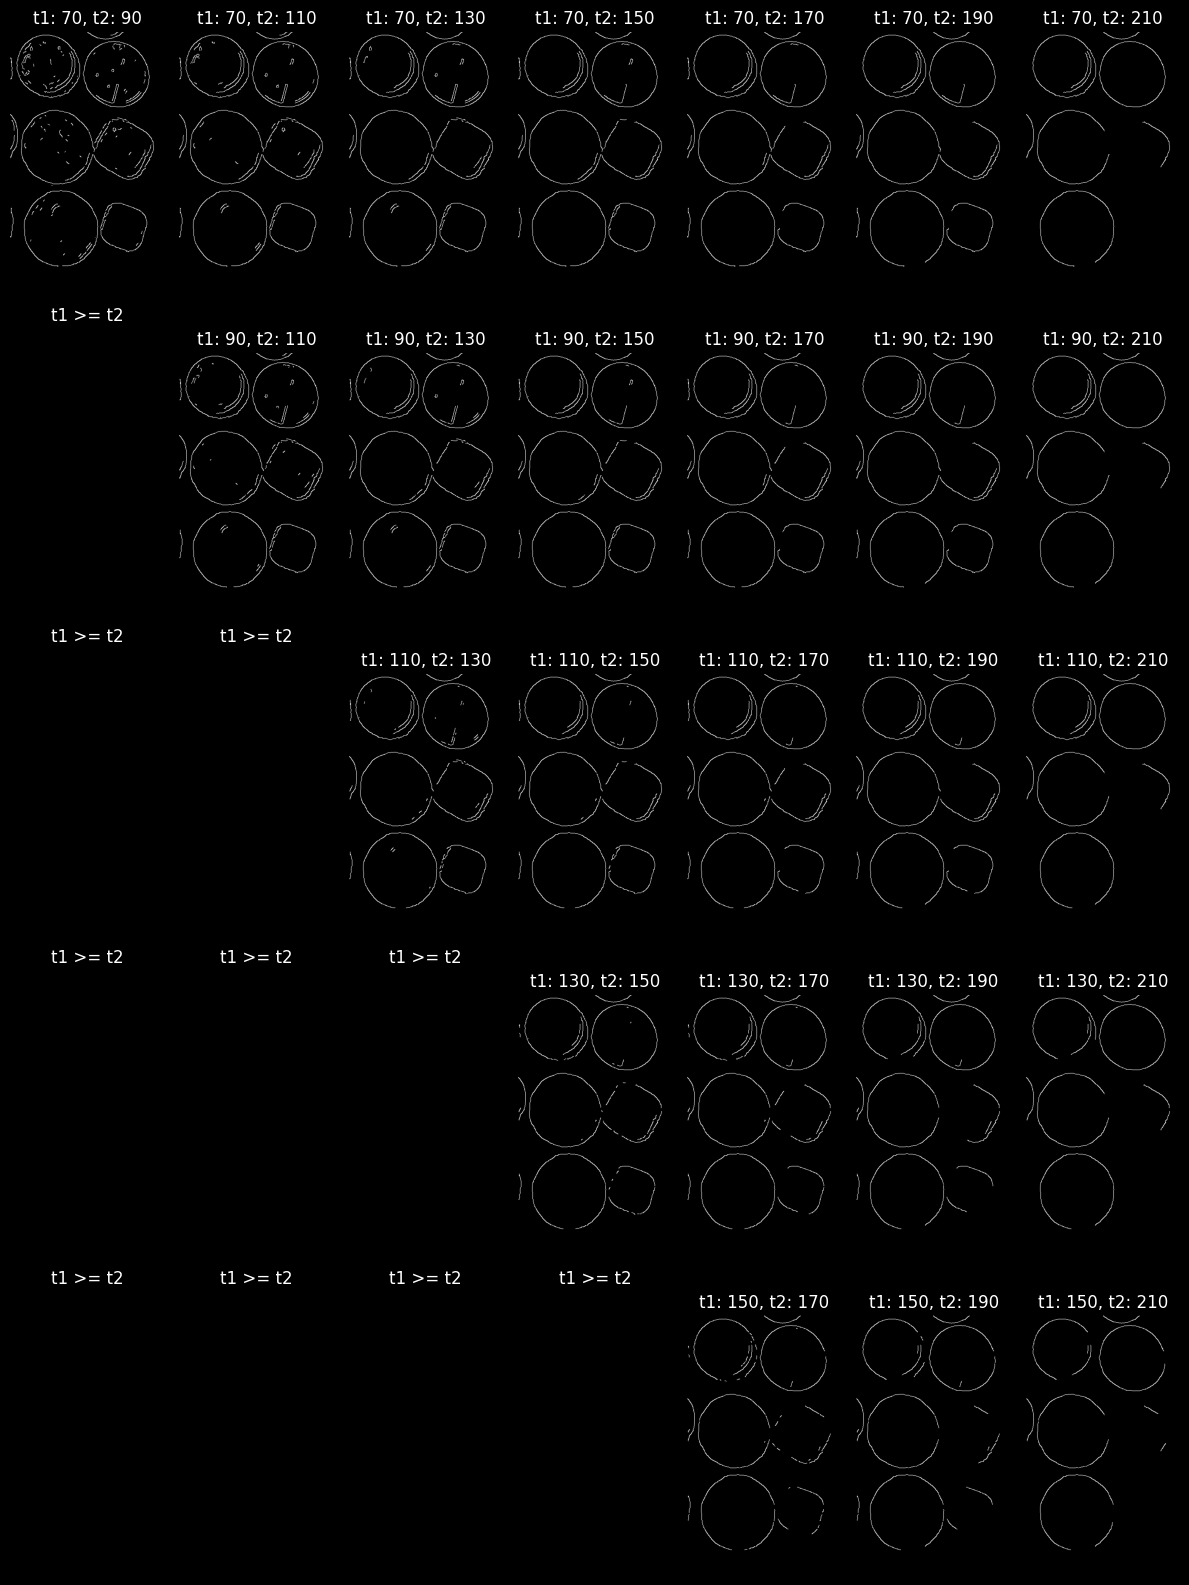

In [10]:
filtered_img = cv2.GaussianBlur(coins_noise, (9, 9), 0)

threshold1_values = [70, 90, 110, 130, 150]
threshold2_values = [90, 110, 130, 150, 170, 190, 210]

plt.figure(figsize=(12, 16))
plot_num = 1

for t1 in threshold1_values:
  for t2 in threshold2_values:
    if t1 >= t2:
      plt.subplot(len(threshold1_values), len(threshold2_values), plot_num)
      plt.title(f't1 >= t2')
      plt.axis('off')
      plot_num += 1
      continue
    else:
      edges = cv2.Canny(filtered_img, threshold1=t1, threshold2=t2)

      plt.subplot(len(threshold1_values), len(threshold2_values), plot_num)
      plt.imshow(edges, cmap='gray')
      plt.title(f't1: {t1}, t2: {t2}')
      plt.axis('off')
      plot_num += 1

plt.tight_layout()
plt.show()

---

##### Zad. 3: Wyrównanie histogramu

Wyrównaj histogram obrazu `coins_noise`. Wyniki zaprezentuj za pomocą obrazów i towarzyszących im histogramów. Oceń uzyskaną zmianę w obrazie.

In [11]:
coins_eq = cv2.equalizeHist(coins_noise)

filtered_img = cv2.GaussianBlur(coins_noise, (7, 7), 0)
filtered_coins_eq = cv2.equalizeHist(filtered_img)

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs[0, 0].imshow(coins_noise, cmap='gray')
axs[0, 0].set_title('Obraz Oryginalny')
axs[0, 0].axis('off')
axs[1, 0].hist(coins_noise.flatten(), bins=255)

axs[0, 1].imshow(coins_eq, cmap='gray')
axs[0, 1].set_title('Obraz po wyrównaniu histogramu')
axs[0, 1].axis('off')
axs[1, 1].hist(coins_eq.flatten(), bins=255)

axs[0, 2].imshow(filtered_img, cmap='gray')
axs[0, 2].set_title('Obraz Odszumiony')
axs[0, 2].axis('off')
axs[1, 2].hist(filtered_img.flatten(), bins=255)

axs[0, 3].imshow(filtered_coins_eq, cmap='gray')
axs[0, 3].set_title('Obraz odszumiony po wyrównaniu histogramu')
axs[0, 3].axis('off')
axs[1, 3].hist(filtered_coins_eq.flatten(), bins=255)

plt.tight_layout()
plt.show()

In [13]:
coins_stretch = cv2.normalize(coins_noise, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

filtered_img = cv2.GaussianBlur(coins_noise, (7, 7), 0)
filtered_coins_stretch = cv2.normalize(filtered_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

---

##### Zad. 4: Transformacja do rozkładu docelowego

Dla obrazu `hare_gray` wykonaj transformację do wybranego (założonego przez siebie) rozkładu docelowego, tak aby zmaksymalizować możliwość wyodrębnienia obiektu z otoczenia (zająca) przy użyciu algorytmu binaryzacji Otsu. Zacznij od zastanowienia się nad doborem rozkładu docelowego (możesz zbadać zachowanie transformacji w zależności od wybranego rozkładu).

Podpowiedź: przedstawiona we wstępie teoretycznym transformacja obu rozkładów (źródłowego i docelowego) do rozkładu jednostajnego _nie musi_ zostać faktycznie wykonana (dlatego nie używaj w zadaniu funkcji `cv2.equalizeHist`)! Wystarczy porównywanie ze sobą wartości ze skumulowanych rozkładów (rysunek 3).

Podpowiedź 2: [cv2.LUT](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f)

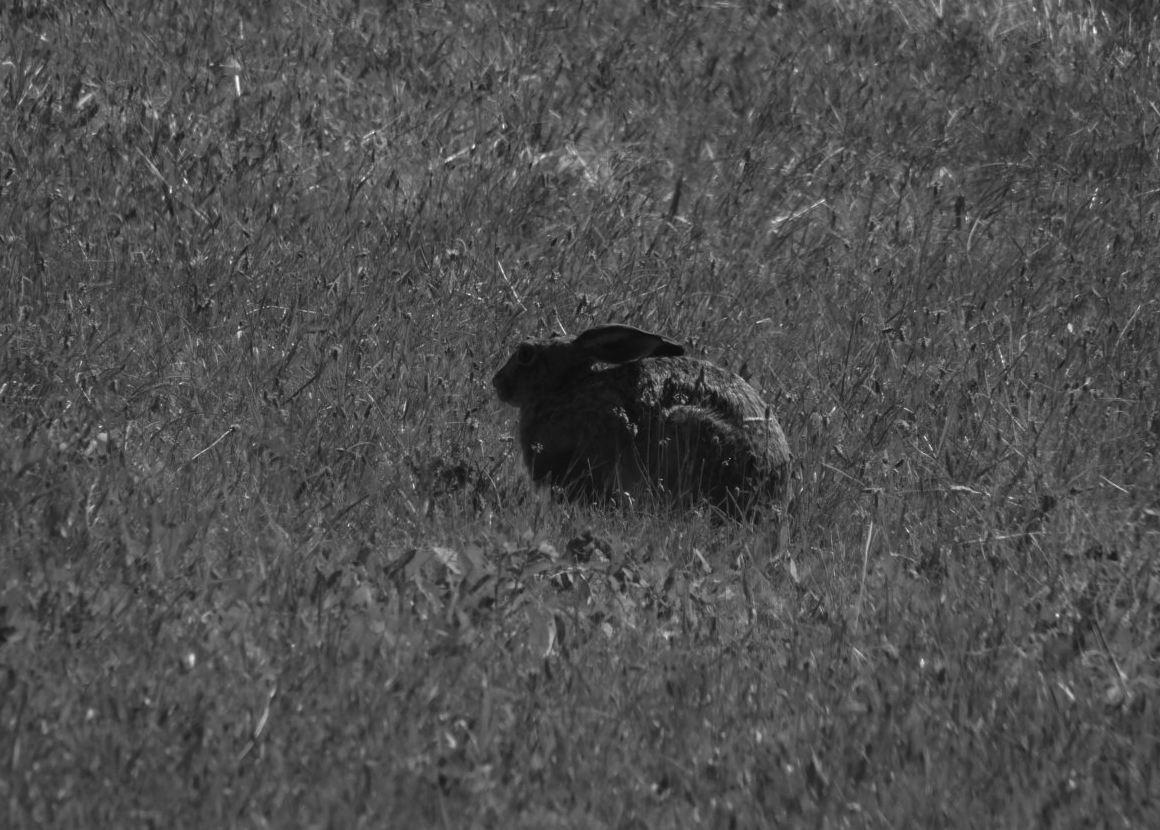

In [14]:
hare_gray = cv2.imread('dane1-4/Zajac.jpg', cv2.IMREAD_GRAYSCALE)
Image.fromarray(hare_gray)

Rozwiązanie:

In [15]:
def compute_histogram(img):
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    hist = hist.flatten()

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    return hist, cdf_normalized

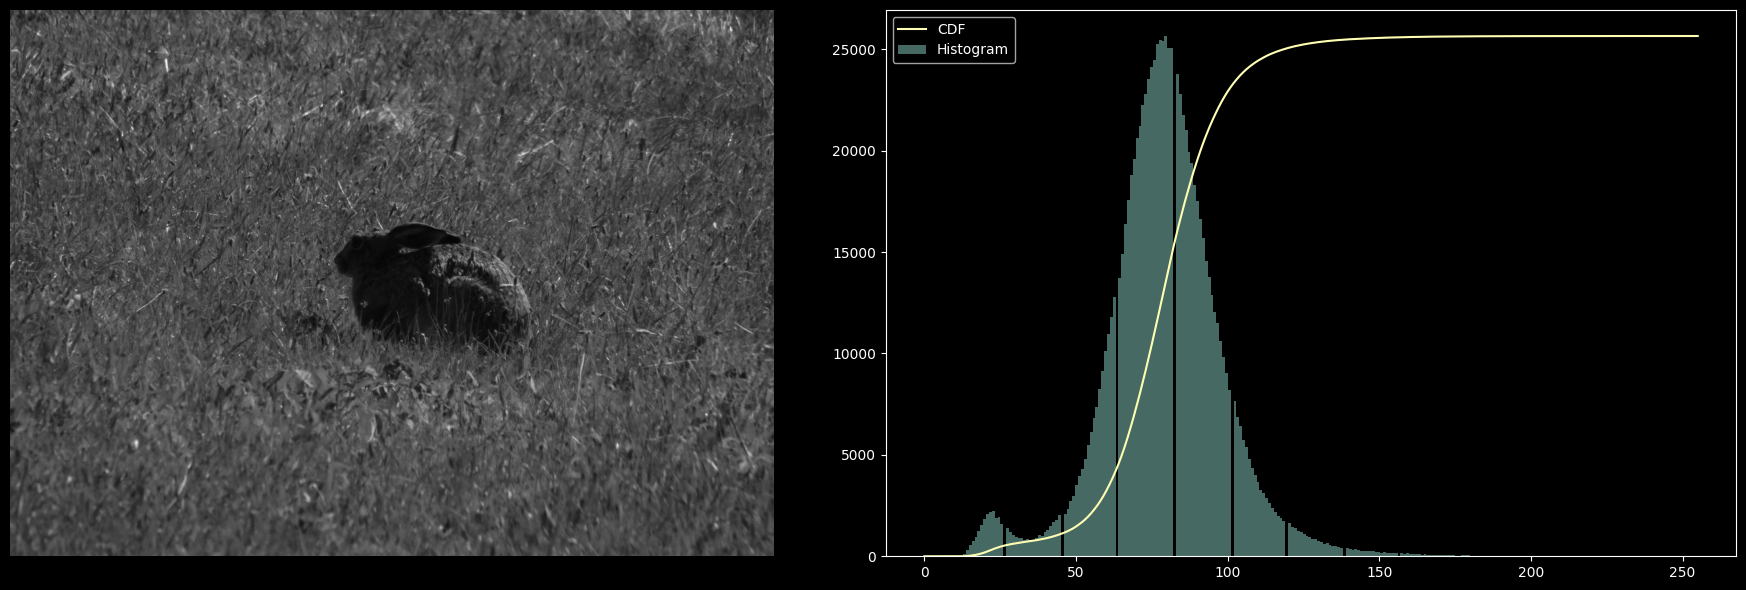

In [16]:
hist, cdf = compute_histogram(hare_gray)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].imshow(hare_gray, cmap='gray')
axs[0].axis('off')
axs[1].hist(hare_gray.flatten(), bins=255, alpha=0.5)
axs[1].plot(cdf)
plt.legend(('CDF','Histogram'), loc='upper left')
plt.tight_layout()
plt.show()

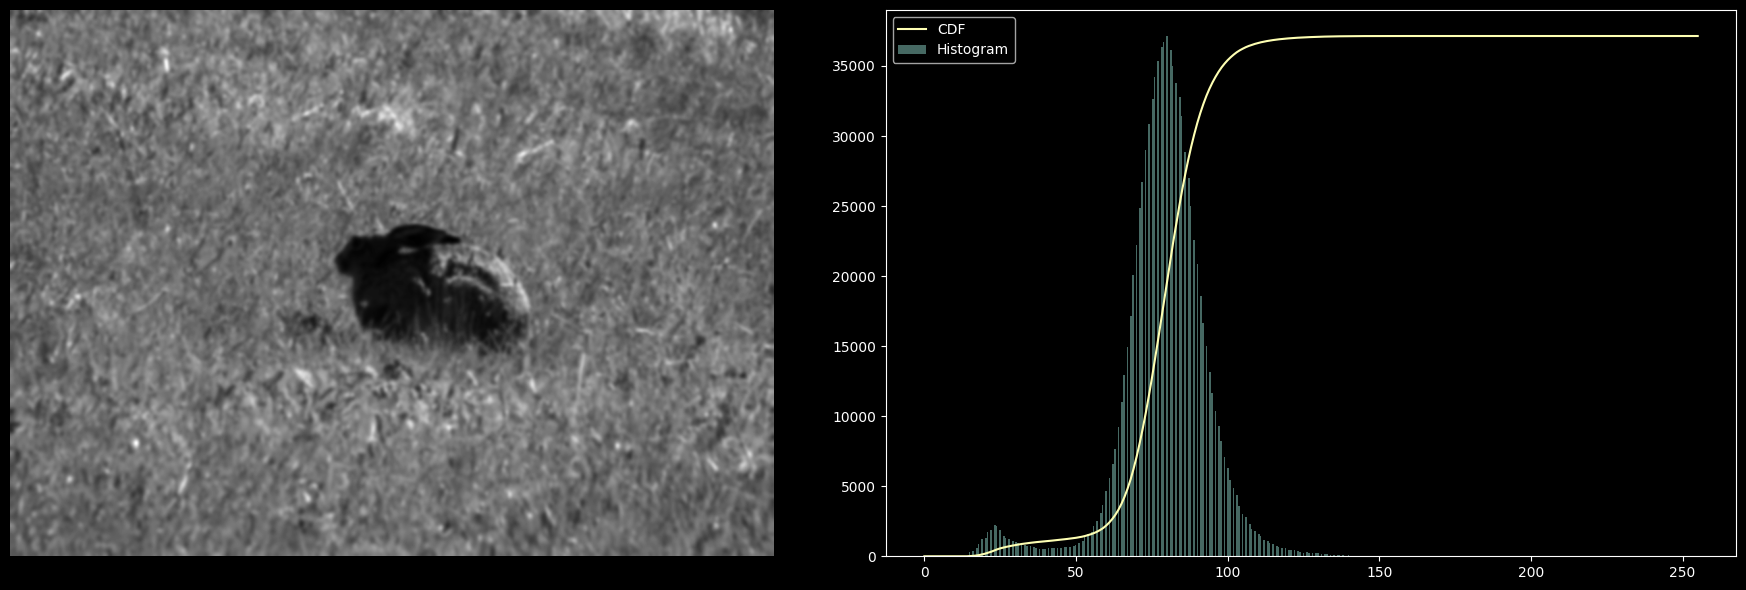

In [17]:
here_blurred = cv2.GaussianBlur(hare_gray, (15, 15), sigmaX=0)

blurred_hist, blurred_cdf = compute_histogram(here_blurred)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].imshow(here_blurred, cmap='gray')
axs[0].axis('off')
axs[1].hist(here_blurred.flatten(), bins=255, alpha=0.5)
axs[1].plot(blurred_cdf)
plt.legend(('CDF','Histogram'), loc='upper left')
plt.tight_layout()
plt.show()

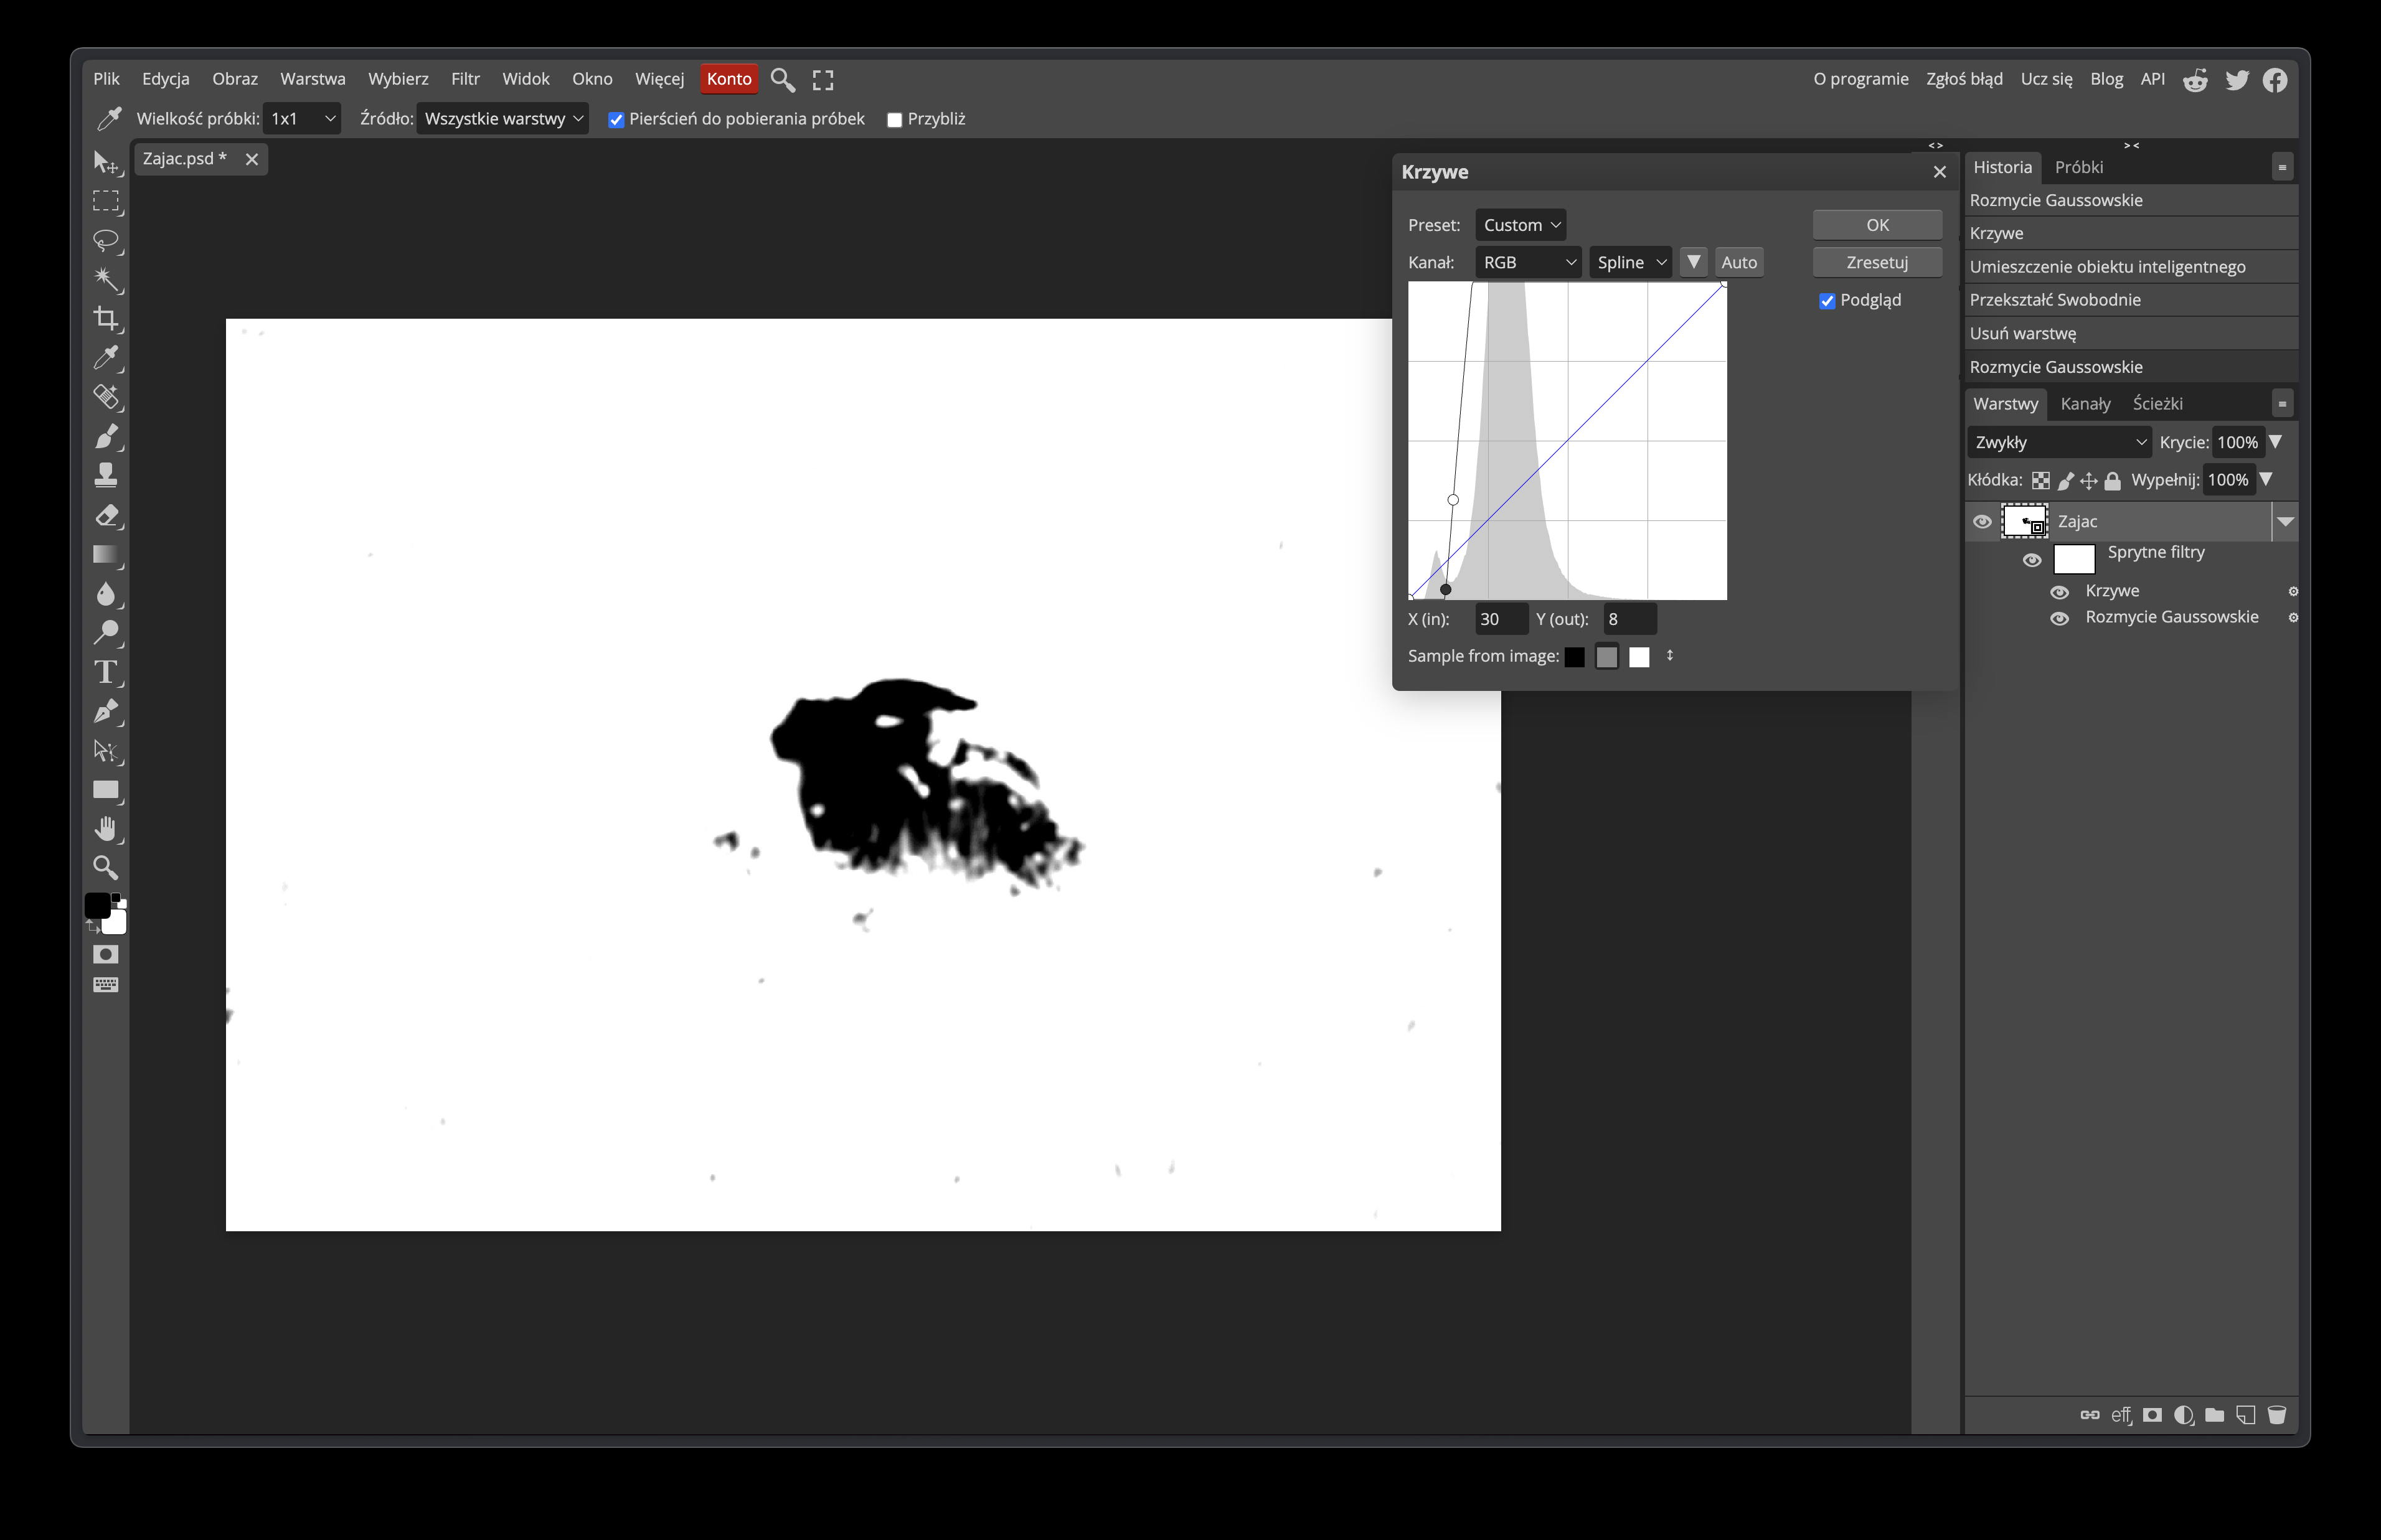

In [27]:
photoshop = cv2.imread('dane1-4/lab3_photoshop.png', cv2.COLOR_BGR2RGB)
Image.fromarray(cv2.cvtColor(photoshop, cv2.COLOR_BGR2RGB))

In [28]:
control_points = np.array([
    [0, 0],                 # pix 0 remains 0
    [30, 8],                # pix 30 becomes 8
    [36, 80],               # pix 36 becomes 80
    [255, 255]              # pix 255 remains 255
], dtype=np.float32)

x_cp = control_points[:, 0]
y_cp = control_points[:, 1]

In [39]:
spline_func = CubicSpline(x_cp, y_cp)

pixel_values = np.arange(256)
mapped_values = spline_func(pixel_values)

mapped_values = np.clip(mapped_values, 0, 255).astype(np.uint8)
# print(mapped_values)

adjusted = cv2.LUT(here_blurred, mapped_values)

adjusted_hist, adjusted_cdf = compute_histogram(adjusted)

In [30]:
_, binary = cv2.threshold(adjusted, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary_hist, _ = compute_histogram(binary)

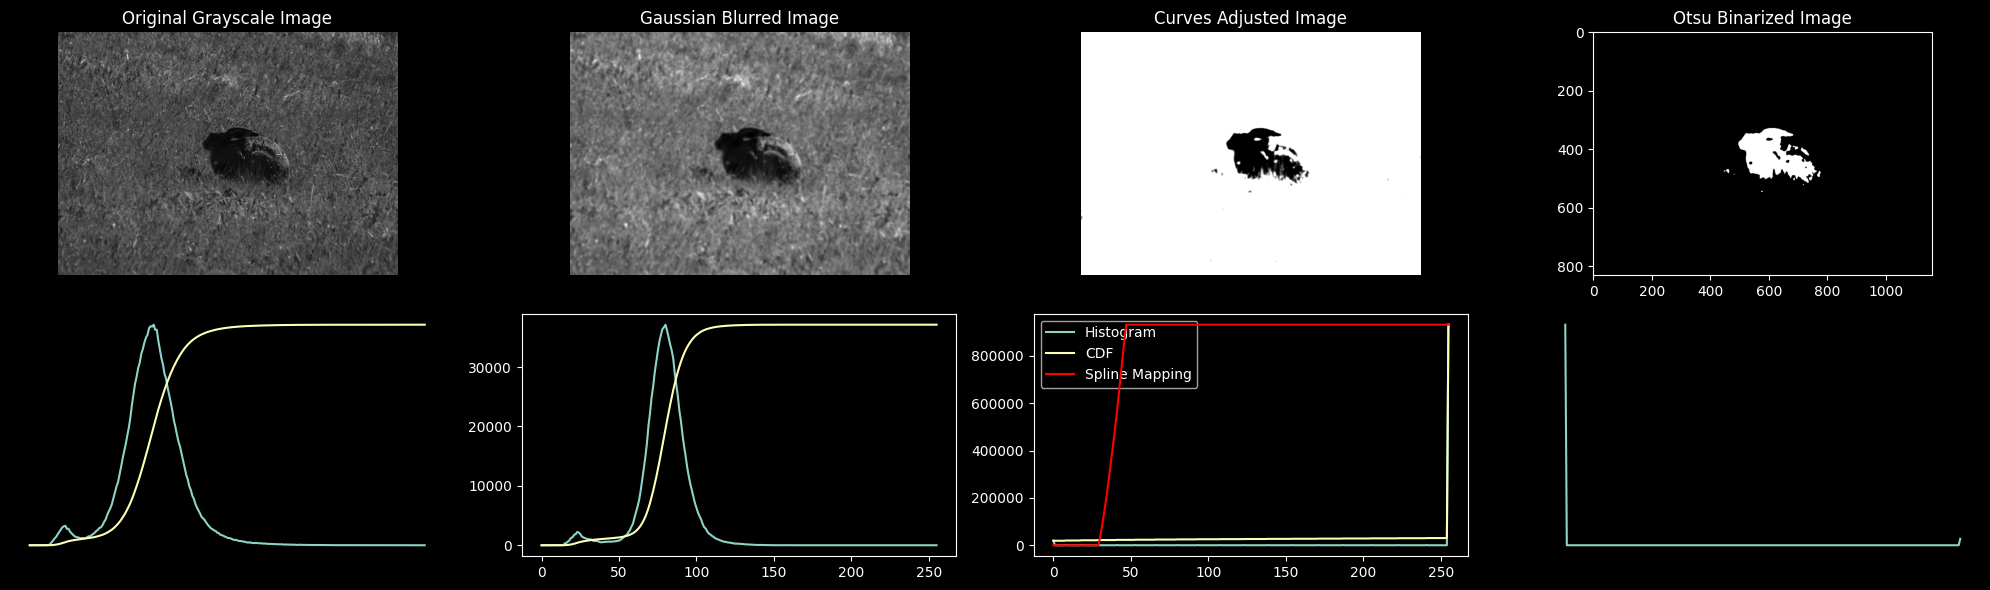

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(20, 6))

axes[0, 0].imshow(hare_gray, cmap='gray')
axes[0, 0].set_title('Original Grayscale Image')
axes[0, 0].axis('off')
axes[1, 0].plot(hist)
axes[1, 0].plot(cdf)
axes[1, 0].axis('off')

axes[0, 1].imshow(here_blurred, cmap='gray')
axes[0, 1].set_title('Gaussian Blurred Image')
axes[0, 1].axis('off')
axes[1, 1].plot(blurred_hist)
axes[1, 1].plot(blurred_cdf)
# axes[1, 1].axis('off')

axes[0, 2].imshow(adjusted, cmap='gray')
axes[0, 2].set_title('Curves Adjusted Image')
axes[0, 2].axis('off')
ax_hist = axes[1, 2]
ax_hist.plot(adjusted_hist, label='Histogram')
ax_hist.plot(adjusted_cdf, label='CDF')
ax_curve = ax_hist.twinx()
ax_curve.plot(pixel_values, mapped_values, color='red', label='Spline Mapping')

lines, labels = ax_hist.get_legend_handles_labels()
lines2, labels2 = ax_curve.get_legend_handles_labels()
ax_hist.legend(lines + lines2, labels + labels2, loc='upper left')
# ax_hist.axis('off')
ax_curve.axis('off')

axes[0, 3].imshow(binary, cmap='gray')
axes[0, 3].set_title('Otsu Binarized Image')
# axes[0, 3].axis('off')
axes[1, 3].plot(binary_hist)
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

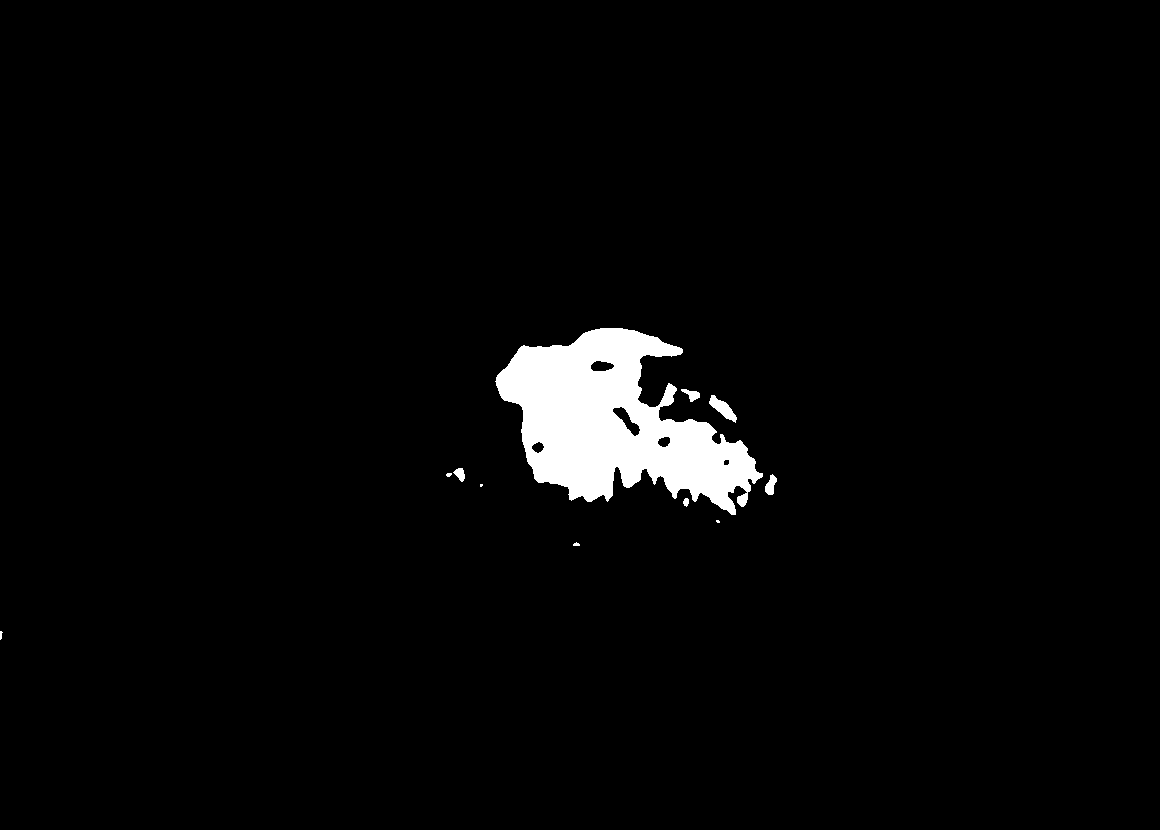

In [32]:
Image.fromarray(binary)